# [ASSIGNMENT-3] Klasifikasi cats vs dogs menggunakan supervised learning
Nama : Ichwan Rizky Wahyudin\
NIM : 1301213434\
Kelas : IF-45-09\
Metode : Support Vector Machine(SVM)\
Link Source Code : https://github.com/irizkyw/ComputerVision/tree/ASSIGNMENTS/W5_Assignment3

In [1]:
import os
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from skimage import color, io
from skimage.transform import resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
image_size = (100,100)
dataset_dir = f"data/"
train_dir = os.path.join(dataset_dir, "train")
validation_dir = os.path.join(dataset_dir, "validation")

### Load Data

In [3]:
def load_images_from_folder(folder_path, image_size):
    features = []
    labels = []

    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        for image_file in os.listdir(subfolder_path):
            try:
                img = cv2.imread(os.path.join(subfolder_path, image_file))
                if img is None:
                    print(f"Image {image_file} could not be loaded")
                    continue

                img = cv2.resize(img, image_size)
                normalized_img = img / 255.0
                flattened_img = normalized_img.flatten() 
                features.append(flattened_img)

                labels.append(1 if subfolder == 'dogs' else 0)
            except Exception as e:
                print(f"Error: {e}")

    features = np.array(features)
    labels = np.array(labels)

    return features, labels

X_train, y_train = load_images_from_folder(train_dir, image_size)
X_validation, y_validation = load_images_from_folder(validation_dir, image_size)

### Image preprocessing & Augmentation

In [4]:
shuffle_index = np.random.permutation(len(X_train))
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [5]:
def add_noise(image, mean=0, var=0.001):
    row, col, ch = image.shape
    sigma = var ** 0.5
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    noisy_image = image + gauss
    noisy_image = np.clip(noisy_image, 0, 255)
    return noisy_image.astype(np.float32)


datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=add_noise
)

In [6]:
X_train_reshaped = X_train.reshape(-1, image_size[0], image_size[1], 3)
datagen.fit(X_train_reshaped)

In [7]:
augmented_images = []
augmented_labels = []

for images, labels in datagen.flow(X_train_reshaped, y_train, batch_size=len(X_train)):
    augmented_images.append(images.reshape(len(X_train), -1))
    augmented_labels.append(labels)
    break

X_train_augmented = np.vstack(augmented_images)
y_train_augmented = np.hstack(augmented_labels)

### Samples Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


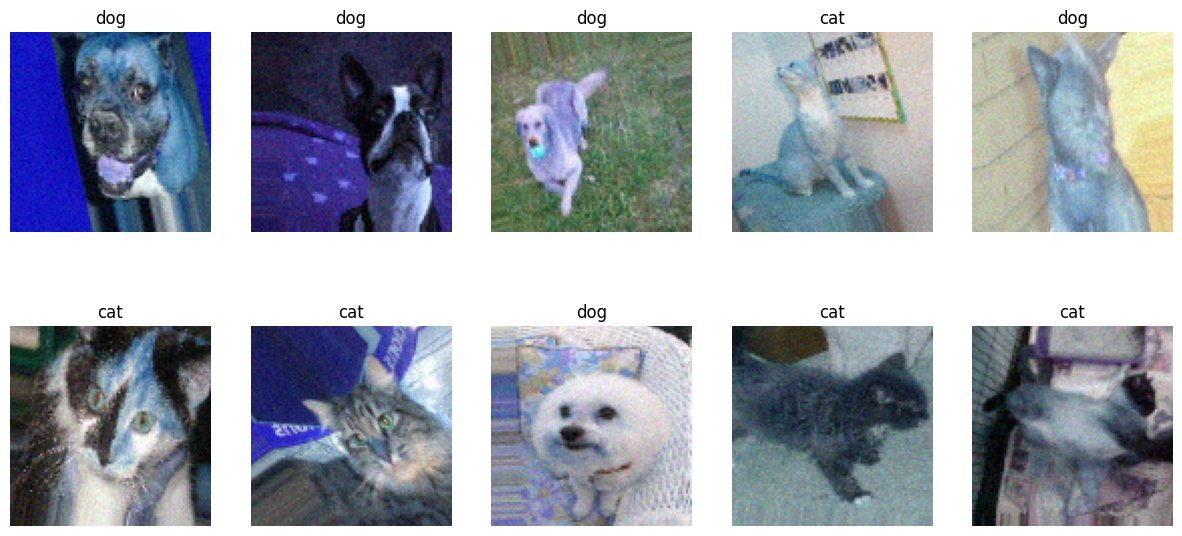

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(15, 7))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train_augmented[i].reshape(image_size[0], image_size[1], 3))
    ax.axis('off')
    ax.set_title('dog' if y_train_augmented[i] == 1 else 'cat')
    
plt.show()

### Training Model SVM

In [9]:
import time
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
n = 0.8
svm = SVC(class_weight='balanced')
pca = PCA(n_components=n, random_state=42)

pipeline = Pipeline(steps=[('pca', pca), ('svm', svm)])

In [26]:
param_grid = {
    'pca__n_components': [0.8,0.9,1],
    'svm__C': [0.1],
    'svm__kernel': ['rbf', 'linear', 'poly']
}

In [27]:
grid_search = GridSearchCV(pipeline, param_grid, cv=3, verbose=4)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[CV 1/3] END pca__n_components=0.8, svm__C=0.1, svm__kernel=rbf;, score=0.576 total time=  33.8s
[CV 2/3] END pca__n_components=0.8, svm__C=0.1, svm__kernel=rbf;, score=0.580 total time=  28.6s
[CV 3/3] END pca__n_components=0.8, svm__C=0.1, svm__kernel=rbf;, score=0.596 total time=  26.0s
[CV 1/3] END pca__n_components=0.8, svm__C=0.1, svm__kernel=linear;, score=0.561 total time=  25.9s
[CV 2/3] END pca__n_components=0.8, svm__C=0.1, svm__kernel=linear;, score=0.576 total time=  24.2s
[CV 3/3] END pca__n_components=0.8, svm__C=0.1, svm__kernel=linear;, score=0.590 total time=  25.5s
[CV 1/3] END pca__n_components=0.8, svm__C=0.1, svm__kernel=poly;, score=0.547 total time=  23.7s
[CV 2/3] END pca__n_components=0.8, svm__C=0.1, svm__kernel=poly;, score=0.537 total time=  25.3s
[CV 3/3] END pca__n_components=0.8, svm__C=0.1, svm__kernel=poly;, score=0.586 total time=  24.6s
[CV 1/3] END pca__n_components=0.9, svm__C=0.1, svm__kernel=rbf;, score=0.594 total time=  25.3s
[CV 2/3] END pca__

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca',
                                        PCA(n_components=0.8, random_state=42)),
                                       ('svm', SVC(class_weight='balanced'))]),
             param_grid={'pca__n_components': [0.8, 0.9, 1], 'svm__C': [0.1],
                         'svm__kernel': ['rbf', 'linear', 'poly']},
             verbose=4)

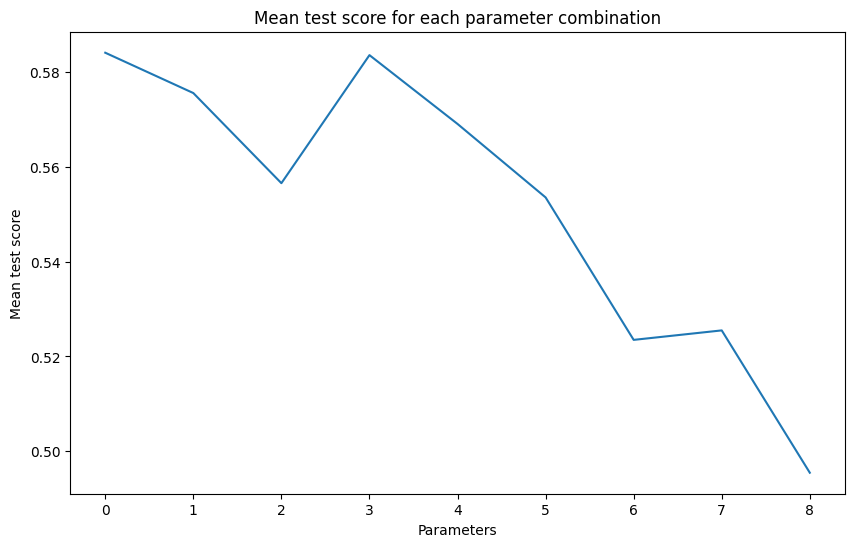

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(grid_search.cv_results_['mean_test_score'])
plt.xlabel('Parameters')
plt.ylabel('Mean test score')
plt.title('Mean test score for each parameter combination')
plt.show()

In [29]:
y_train_pred = grid_search.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)
print(f"Accuracy on training set: {accuracy_train}")

Accuracy on training set: 0.6455


### Use best parameter for evaluate

In [30]:
best_pipeline = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best score:", best_score)

Best parameters: {'pca__n_components': 0.8, 'svm__C': 0.1, 'svm__kernel': 'rbf'}
Best score: 0.5840060450255353


In [31]:
accuracy = best_pipeline.score(X_validation, y_validation)
print("Validation accuracy:", accuracy)

Validation accuracy: 0.611


In [32]:
# save model
import joblib
joblib.dump(best_pipeline, 'model_svm.pkl')
print("Model saved as model_svm.pkl")

Model saved as model_svm.pkl


### Report Models

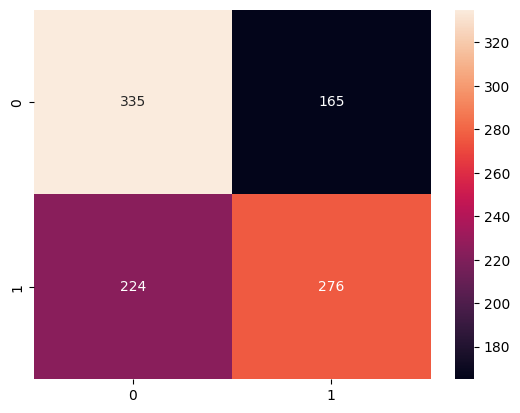

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = best_pipeline.predict(X_validation)
cm = confusion_matrix(y_validation, y_pred)

sns.heatmap(cm, annot=True, fmt='d')
plt.show()

# Test Model menggunakan data uji/testing_data

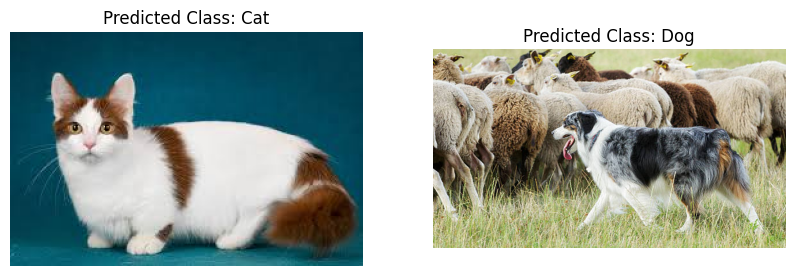

In [45]:
import cv2
import numpy as np
import joblib
import matplotlib.pyplot as plt

# Load model
model = joblib.load('model_svm.pkl')

def preprocess_image(image_path, image_size):
    img = cv2.imread(image_path)
    img = cv2.resize(img, image_size)
    img = img / 255.0  
    img = img.flatten()
    return img

def classify_images(image_paths, model):
    predictions = []
    for image_path in image_paths:
        img = preprocess_image(image_path, image_size)
        img = img.reshape(1, -1)
        prediction = model.predict(img)
        predictions.append(prediction[0])
    return predictions

image_paths = ['testing_data/6_cat.jpeg', 'testing_data/10_anjing.jpeg']
predictions = classify_images(image_paths, model)
class_labels = ['Cat', 'Dog']

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, image_path in enumerate(image_paths):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img_rgb)
    axes[i].set_title('Predicted Class: ' + class_labels[predictions[i]])
    axes[i].axis('off')

plt.show()